In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical, Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from sklearn.utils import shuffle
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pickle as pkl
import face_recognition
import subprocess
import shlex
import json
import cv2
import os

In [23]:
IMG_SIZE = 64
CHANNELS = 1
# Max amount of frames loaded
N_FRAMES = 10
# Sequence at which the frames are loaded into the model
SEQ_LEN = 10
# Max frames per video
MAX_FRAMES = 7200

# Working directories
cwd = os.path.basename(os.getcwd())
# Inside Data_set there is a folder for each participant with both categories corresponding to that person
# 'Alert' and 'Drowsy'
path = os.path.basename(os.path.join(os.getcwd(),'Data_set'))

In [3]:
# Build inceptionV3 feature extractor
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

In [4]:
# Gets the rotation of a video
def get_rotation(file_path_with_file_name):
    """
    Function to get the rotation of the input video file.
    Adapted from gist.github.com/oldo/dc7ee7f28851922cca09/revisions using the ffprobe comamand by Lord Neckbeard from
    stackoverflow.com/questions/5287603/how-to-extract-orientation-information-from-videos?noredirect=1&lq=1

    Returns a rotation None, 90, 180 or 270
    """
    cmd = "ffprobe -loglevel error -select_streams v:0 -show_entries stream_tags=rotate -of default=nw=1:nk=1"
    args = shlex.split(cmd)
    args.append(file_path_with_file_name)
    # run the ffprobe process, decode stdout into utf-8 & convert to JSON
    ffprobe_output = subprocess.check_output(args).decode('utf-8')
    if len(ffprobe_output) > 0:  # Output of cmdis None if it should be 0
        ffprobe_output = json.loads(ffprobe_output)
        rotation = ffprobe_output

    else:
        rotation = 0

    return rotation 

# Corrects the video to showup vertical
def correct_rot(image, rot):
    img = image
    if rot == 90:
        img = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    if rot == 180:
        img = cv2.rotate(image, cv2.ROTATE_180)
    if rot == 270:
        img = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    return img

In [5]:
# Load the labels from each video's file name
def load_category(file):
    
    if file.endswith(('0.mp4','0.mov','0.MOV','0.MP4','0.m4v')):      
        label = 'Alert'
        
    elif file.endswith(('5.mp4','5.mov','5.MOV','5.MP4','5.m4v')):
        label = 'Low Vigilant'
    else:
        label = 'Drowsy'
        
    return label


# Construct the data matrix with each video path and corresponding label
def build_matrix(path):
    #Iterates through the directories
    dirs = os.listdir( path )
    paths_list = []
    label_list = []
    for folder in dirs:
        if folder != '.DS_Store':
            # Each folder contains 3 videos from the same person
            sub_path = os.path.join(path,folder)
            for file in os.listdir(sub_path):
                if file != '.DS_Store':
                    # State the path to each video
                    video_path = os.path.join(sub_path,file)
                    # Load the category depending on the name of the video
                    label = load_category(video_path)
                    if label != 'Low Vigilant':
                        # Variables to return the paths to the videos and its labels
                        paths_list.append(video_path)
                        label_list.append(label)
    # Traspose the matrix to return (116,2) --> rows: each video; columns: attribute
    data = np.transpose([paths_list,label_list])
    
    return data

# Convert labels to dictionary 
def define_dict(X, col):
    
    #Define dictionary
    dict_labels = X[:,col]
    labelsNames = np.unique(dict_labels)
    labelsDict = dict(zip(labelsNames,range(len(labelsNames))))
    labels = np.array([labelsDict[cl] for cl in dict_labels])
    
    #change column with dictionary values
    X = np.delete(X,col,1)
    
    return X, labels, labelsDict

In [6]:
# Build matrix with paths and labels
data = build_matrix(path)
# Return dictionary and labels for each video
video_paths, labels_pre, labelsDict = define_dict(data,1)
# Reduce one dimension from video_paths. From: (116,1) to (116,)
video_paths = video_paths.squeeze(axis=1)
# Transform the labels category from integer values to one-hot encoding
labels_one_hot = to_categorical(labels_pre)

print('Videos found: ', len(video_paths))
print('Labels found: ', labelsDict)

Videos found:  116
Labels found:  {'Alert': 0, 'Drowsy': 1}


In [7]:
# Display video detecting the face and eyes
def show_video(path,frame_rate=1):
    cap = cv2.VideoCapture(path)
    # Gets the rotation from the video
    rot = get_rotation(path)
    
    # Detects the face and eyes from the people in the video
    haarcascade_folder = os.path.join(os.getcwd(),'haarcascades')
    face_cascade = cv2.CascadeClassifier(os.path.join(haarcascade_folder,'haarcascade_frontalface_default.xml'))
    eye_cascade = cv2.CascadeClassifier(os.path.join(haarcascade_folder,'haarcascade_eye.xml'))
    
    count = 0
     
    while True:
        ret, frame = cap.read()
        
        # Detect if a frame is successfully readed
        if not ret:
            break
        
        # Load frames at the speed of the frame rate
        if count % frame_rate == 0:
            # Corrects the rotation from the frame
            frame = correct_rot(frame,rot)
            # Convert to gray  scale the frame
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Detect the faces
            faces = face_cascade.detectMultiScale(gray,1.3,5)
            
            # Display the results
            for (x,y,w,h) in faces:
                cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 2) # Displays a rectangle for the face
                
                roi_gray = gray[y:y+h, x:x+w]
                roi_color = frame[y:y+h, x:x+w]
                eyes = eye_cascade.detectMultiScale(roi_gray,1.3,5)
                
                for (ex,ey,ew,eh) in eyes:
                    cv2.rectangle(roi_color, (ex,ey), (ex+ew,ey+eh), (255,0,0), 2) # Displays a rectangle for the eyes
            
            # Display video
            cv2.imshow('Video', frame)
            
            # Stop if escape key is pressed
            k = cv2.waitKey(30) & 0xff
            if k==27:
                break
            
        count += 1
        
    # Good practice to close all windows while releasing the video capture function from OpenCV
    cap.release()
    cv2.destroyAllWindows()

In [11]:
show_video(video_paths[0])

In [8]:
# Show face frames if needed
def show_face(folder_path,path,n_frames,resize=(IMG_SIZE,IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    base = os.path.basename(os.path.dirname(path))
    rot = get_rotation(path)
    
    
    haarcascade_folder = os.path.join(os.getcwd(),'haarcascades')
    face_cascade = cv2.CascadeClassifier(os.path.join(haarcascade_folder,'haarcascade_frontalface_default.xml'))
    
    count = 0
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        if count == n_frames:
            break
        
        frame = correct_rot(frame,rot)
        
        # Convert to gray  scale the frame
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Detect the faces
        faces = face_cascade.detectMultiScale(gray,1.3,5)
    
        # Display the results
        for (x,y,w,h) in faces:
            # Crop the frame to leave only the face
            face_frame = frame[y:y+h, x:x+w]
        
        
        if 'face_frame' in locals(): #Face detected
            frame = cv2.resize(face_frame,resize)
            n = base + '_' + str(count) + '.jpg'
            name = os.path.join(folder_path,n)
            cv2.imwrite(name, frame)
            count += 1
            
    cap.release()
    cv2.destroyAllWindows()
    print('\nDone saving images')

In [29]:
def load_frames(video_path,category,frame_rate=1,frame_count=N_FRAMES,max_frames=MAX_FRAMES,resize=(IMG_SIZE,IMG_SIZE)):
    cap = cv2.VideoCapture(video_path)
    rot = get_rotation(video_path)
    base = os.path.basename(os.path.dirname(video_path))
    
    haarcascade_folder = os.path.join(os.getcwd(),'haarcascades')
    face_cascade = cv2.CascadeClassifier(os.path.join(haarcascade_folder,'haarcascade_frontalface_default.xml'))
  
    count = 0
    count_f = 0
    frames = []
    labels = []
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        if count == max_frames or count_f == frame_count:
            break
        
        if count % frame_rate == 0:
            frame = correct_rot(frame,rot)
            
            # Convert to gray  scale the frame
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # Detect the faces
            faces = face_cascade.detectMultiScale(gray,1.3,5)
        
            # Display the results
            for (x,y,w,h) in faces:
                # Crop the frame to leave only the face
                face_frame = frame[y:y+h, x:x+w]
            
            
            if 'face_frame' in locals(): #Face detected
                face_gray = cv2.cvtColor(face_frame, cv2.COLOR_BGR2GRAY) # Converts to gray scale
                frame = cv2.resize(face_gray,resize)/255.0 # Resizes the face frame and normilize it
                #pred = feature_extractor.predict(frame[np.newaxis,...])
                frames.append(frame)
                labels.append(category)
                count_f += 1 #One frame loaded
            else: # Face not detected substract counter and try next frame
                count -= 1
        
        count += 1
    
            
    # Good practice to close all windows while releasing the video capture function from OpenCV
    cap.release()
    cv2.destroyAllWindows()
    
    frames = np.array(frames)
    labels = np.array(labels)
    
    return frames, labels

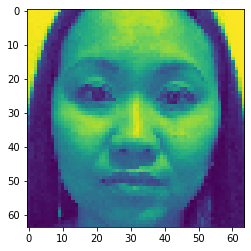

In [31]:
f, _ = load_frames(video_paths[0], labels_pre[0],frame_count=1)
from matplotlib import pyplot as plt
# Plot image in gray scale
plt.imshow(f[0], interpolation='nearest')
plt.show()

In [32]:
x = []
y = []
for i in range(len(video_paths)):
    if i % 10 == 0:
        print(f'Loaded {i} videos out of {len(video_paths)}')
    f, l = load_frames(video_paths[i],labels_one_hot[i])
    x.append(f)
    y.append(l)

# Convert to np.array        
x = np.array(x).expand_dims(axis=-1)
y = np.array(y)  
print("Videos' shape: ", x.shape, "   Labels' shape: ", y.shape)

Loaded 0 videos out of 116
Loaded 10 videos out of 116
Loaded 20 videos out of 116
Loaded 30 videos out of 116
Loaded 40 videos out of 116
Loaded 50 videos out of 116
Loaded 60 videos out of 116
Loaded 70 videos out of 116
Loaded 80 videos out of 116
Loaded 90 videos out of 116
Loaded 100 videos out of 116
Loaded 110 videos out of 116
Videos' shape:  (116, 10, 64, 64)    Labels' shape:  (116, 10, 2)


In [49]:
# Shuffle the matrix with the video_paths and its corresponding labels before the neuronal network
pahts_shuffle, labels_shuffle = shuffle(x, y)
# Split the data to get test set (10%)
x_temp, x_test, y_temp, y_test = train_test_split(pahts_shuffle, labels_shuffle, test_size=0.1, random_state=42)
# Split the data into training and validation (70%-20%   the other 10% of the data is the test set)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.2, random_state=42)

del x_temp, y_temp

print('Sets for training')
print('Training: ', x_train.shape)
print('Validation: ', x_test.shape)
print('Testing: ', x_test.shape)

Sets for training
Training:  (83, 10, 64, 64, 1)
Validation:  (12, 10, 64, 64, 1)
Testing:  (12, 10, 64, 64, 1)


In [55]:
# Training hyperparameters
NUM_EPOCHS = 10
BATCH_SIZE = 1

In [59]:
# Model definition
model = Sequential([
    TimeDistributed(Conv2D(32,(5,5),activation="relu",input_shape = (SEQ_LEN, IMG_SIZE,IMG_SIZE,CHANNELS))),
    TimeDistributed(MaxPooling2D(2,2)),
    TimeDistributed(Conv2D(16,(3,3),activation = "relu")),
    TimeDistributed(MaxPooling2D(2,2)),
    TimeDistributed(Conv2D(8,(3,3),activation = "relu")),
    TimeDistributed(GlobalAveragePooling2D()),
    LSTM(32, activation='relu', return_sequences=False),
    Dense(64,activation="relu"),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32,activation="relu"),
    Dense(2,activation="softmax")
    ])

model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics = ['acc'])

In [60]:
# Train the model
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(x_val,y_val), verbose=1)

Train on 83 samples, validate on 21 samples
Epoch 1/10
83/83 [==============================] - 9s 108ms/sample - loss: 0.6932 - acc: 0.4639 - val_loss: 0.6928 - val_acc: 0.6190
Epoch 2/10
83/83 [==============================] - 4s 49ms/sample - loss: 0.6932 - acc: 0.4578 - val_loss: 0.6932 - val_acc: 0.6190
Epoch 3/10
83/83 [==============================] - 4s 48ms/sample - loss: 0.6932 - acc: 0.5181 - val_loss: 0.6935 - val_acc: 0.6190
Epoch 4/10
83/83 [==============================] - 4s 49ms/sample - loss: 0.6931 - acc: 0.5181 - val_loss: 0.6941 - val_acc: 0.5714
Epoch 5/10
83/83 [==============================] - 4s 50ms/sample - loss: 0.6931 - acc: 0.5181 - val_loss: 0.6948 - val_acc: 0.5238
Epoch 6/10
83/83 [==============================] - 4s 50ms/sample - loss: 0.6931 - acc: 0.5181 - val_loss: 0.6960 - val_acc: 0.5238
Epoch 7/10
83/83 [==============================] - 5s 56ms/sample - loss: 0.6931 - acc: 0.5181 - val_loss: 0.6973 - val_acc: 0.5238
Epoch 8/10
83/83 [======

In [61]:
#Evaluate trained model with test set of data and obtained generalization accuracy
print('\nEvaluating on test data')
_, acc = model.evaluate(x_test,y_test,batch_size=BATCH_SIZE)
print("\nTesting accuracy: ", acc)


Evaluating on test data
12/1 [========================================================================================================================================================================================================================================================================================================================================================================] - 0s 17ms/sample - loss: 0.6769 - acc: 0.7500

Testing accuracy:  0.75


In [62]:
# Model architecture
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis multiple                  832       
_________________________________________________________________
time_distributed_37 (TimeDis multiple                  0         
_________________________________________________________________
time_distributed_38 (TimeDis multiple                  4624      
_________________________________________________________________
time_distributed_39 (TimeDis multiple                  0         
_________________________________________________________________
time_distributed_40 (TimeDis multiple                  1160      
_________________________________________________________________
time_distributed_41 (TimeDis multiple                  0         
_________________________________________________________________
lstm_6 (LSTM)                multiple                 